# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [ ]:
# student details 1: Meshy B. 2864  
# student details 2: Sapir B. 3721

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
The learning task in this assignment is a binary classification problem based on the Titanic dataset
Each row in the dataset represents one passenger with information such as ticket class (Pclass), sex, age, number of siblings or spouses aboard (SibSp), parents or children (Parch), ticket fare, and port of embarkation (Embarked). 
The target variable is “Survived,” where 1 means the passenger survived and 0 means the passenger did not survive. 
The goal is to train models that can predict whether a passenger survived, and to understand which factors had the greatest impact on survival chances. The objective is to make accurate predictions and also to learn what influenced survival on the Titanic.
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [86]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [88]:
# Load the data
train_df = pd.read_csv("titanic_train.csv")
test_df = pd.read_csv("titanic_test.csv")

# Check the shape (rows, columns) of each dataset
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape, "\n")

# Show first 5 rows of each dataset
print("Train set:")
print(train_df.head())

print("\nTest set:")
print(test_df.head())

Train shape: (712, 8)
Test shape: (179, 8) 

Train set:
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0

Test set:
   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1


In [ ]:
EDA

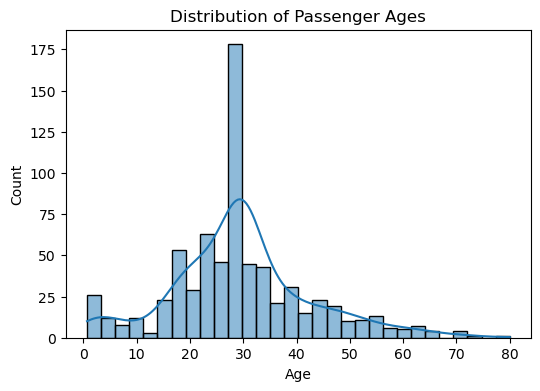

In [90]:
# 1. Age distribution

# The histogram shows the distribution of passenger ages. 
# Most passengers were between 20 and 40 years old. 
    
plt.figure(figsize=(6,4))
sns.histplot(train_df["Age"], bins=30, kde=True)
plt.title("Distribution of Passenger Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

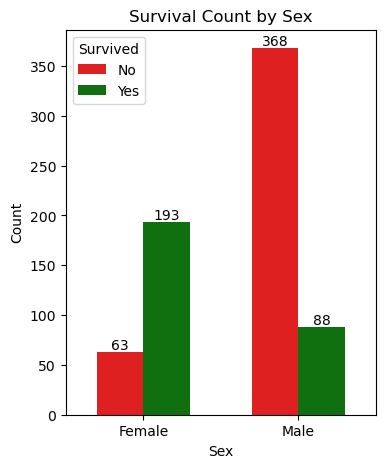

In [92]:
# 2. Survival by Sex

# The countplot shows survival by sex. 
# More women survived compared to men.  

sex_map = {0: "Female", 1: "Male"}
train_df["Sex_label"] = train_df["Sex"].map(sex_map)

plt.figure(figsize=(4,5))
ax = sns.countplot(x="Sex_label", hue="Survived", data=train_df, width=0.6, palette={0: "red", 1: "green"})

plt.title("Survival Count by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])

for p in ax.patches:
    height = p.get_height()
    if height > 0: 
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')
plt.show()


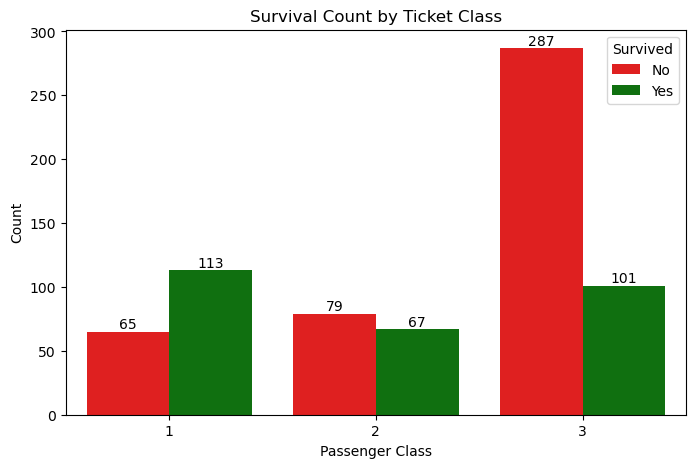

In [94]:
# 3. Survival by Pclass

# The countplot shows survival by ticket class (Pclass). 
# Passengers in 1st class had higher survival rates compared to 2nd and 3rd class.  

plt.figure(figsize=(8,5))
ax = sns.countplot(x="Pclass", hue="Survived", data=train_df, palette={0: "red", 1: "green"} )
plt.title("Survival Count by Ticket Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])

for p in ax.patches:
    height = p.get_height()
    if height > 0:  
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')
        
plt.show()

In [96]:
# 4. Table - Survival rate by Pclass

# 4. The table shows the average survival rate by passenger class. 
# The results confirm that 1st class passengers had the highest chance of survival.  

survival_by_class = train_df.groupby("Pclass")["Survived"].mean().reset_index()

survival_by_class["Survived"] = (survival_by_class["Survived"] * 100).round(1).astype(str) + '%'

print("Survival rate by Passenger Class:")
print(survival_by_class)

Survival rate by Passenger Class:
   Pclass Survived
0       1    63.5%
1       2    45.9%
2       3    26.0%


## Part 3 - Experiments
You could add as many code cells as needed

 We tested the effect of feature engineering (scaling) on the model performance:  
1. No scaling (numeric features left as is).  
2. StandardScaler applied to numeric features.  

We evaluated both configurations using the F1-score with 5-fold cross validation.  
The comparison shows how feature scaling affects model quality.  

In [112]:
# Split columns by type
    # num_cols = numeric columns
    # cat_cols = categorical columns
num_cols = ["Age","Fare","SibSp","Parch","Pclass"]
cat_cols = ["Sex","Embarked"]

# -- FE1: No Scaling --

# For numeric features: fill missing values with median
num_pipe_no = Pipeline([("impute", SimpleImputer(strategy="median"))])

# For categorical features: fill missing values with most frequent and apply OneHotEncoder (convert categories to binary columns)
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),("ohe", OneHotEncoder(handle_unknown="ignore"))])

# Combine numeric and categorical pipelines
pre_no = ColumnTransformer([("num", num_pipe_no, num_cols),("cat", cat_pipe,   cat_cols)])

# Full pipeline: preprocessing + classifier (SVC)
pipe_no = Pipeline([("pre", pre_no), ("clf", SVC())])

# -- FE2: With StandardScaler --

# For numeric features: fill missing values with median + scale data
num_pipe_std = Pipeline([("impute", SimpleImputer(strategy="median")),("scale",  StandardScaler())])

# Combine numeric (with scaling) and categorical pipelines
pre_std = ColumnTransformer([("num", num_pipe_std, num_cols),("cat", cat_pipe,     cat_cols)])

# Full pipeline: preprocessing + classifier (SVC)
pipe_std = Pipeline([("pre", pre_std), ("clf", SVC())])

# ---- Cross Validation ----
    # X = all features (without target column)
    # y = target column (Survived)
X = train_df.drop(columns=["Survived"])
y = train_df["Survived"]

# Define 5-fold cross validation (shuffle for reproducibility)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Run both pipelines (No Scaling and StandardScaler)
# Evaluate performance with F1-score
for name, pipe in [("No Scaling", pipe_no), ("StandardScaler", pipe_std)]:
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")
    print(name, "F1 mean:", round(scores.mean(), 4))


No Scaling F1 mean: 0.4098
StandardScaler F1 mean: 0.751


### Model 1: SVC

We use an SVC with a preprocessing pipeline.  
Numeric features: impute + scale.  
Categorical features: impute + one-hot.  
We tune `C`, `kernel`, and `gamma` with GridSearchCV.  
Evaluation: **F1-score** with **5-fold CV**.


In [151]:
# Define feature groups
num_cols = ["Age", "Fare", "SibSp", "Parch", "Pclass"]
cat_cols = ["Sex", "Embarked"]

# ----- Preprocessing -----
# Numeric pipeline: impute missing values with median + scale
num_pipe_std = Pipeline([("impute", SimpleImputer(strategy="median")),("scale", StandardScaler())])

# Categorical pipeline: impute missing values with most frequent + one-hot encoding
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),("ohe", OneHotEncoder(handle_unknown="ignore"))])

# Combine both pipelines
preprocessor = ColumnTransformer([("num", num_pipe_std, num_cols),("cat", cat_pipe,    cat_cols)])

# ----- Build full pipeline with SVC -----
svc_pipeline = Pipeline([
    ("pre", preprocessor),       # preprocessing step
    ("clf", SVC(class_weight="balanced"))  # classifier (handles class imbalance)
])

# ----- Define hyperparameter grid -----
param_grid_svc = {
    "clf__kernel": ["linear", "rbf"],"clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"]  # gamma relevant only for rbf
}

# ----- Cross-validation setup -----
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ----- GridSearchCV -----
grid_svc = GridSearchCV(
    estimator=svc_pipeline,param_grid=param_grid_svc,
    scoring="f1",      # evaluation metric
    cv=cv,n_jobs=-1,refit=True,return_train_score=False)

# ----- Train the model -----
grid_svc.fit(X, y)

# ----- Print results -----
print("SVC - best params:", grid_svc.best_params_)
print("SVC - best CV F1:", round(grid_svc.best_score_, 4))

# Show top 10 configurations
svc_results = pd.DataFrame(grid_svc.cv_results_)
param_cols = [c for c in svc_results.columns if c.startswith("param_")]
svc_table = svc_results[["mean_test_score", "std_test_score", "rank_test_score"] + param_cols].sort_values("mean_test_score", ascending=False)

print("\nTop configurations (sorted by mean CV F1):")
print(svc_table.head(10).round(4).to_string(index=False))

# Save best model for later use on the test set
best_svc_model = grid_svc.best_estimator_


SVC - best params: {'clf__C': 1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
SVC - best CV F1: 0.7544

Top configurations (sorted by mean CV F1):
 mean_test_score  std_test_score  rank_test_score  param_clf__C param_clf__gamma param_clf__kernel
          0.7544          0.0155                1           1.0             auto               rbf
          0.7525          0.0206                2           1.0            scale               rbf
          0.7412          0.0164                3           0.1            scale               rbf
          0.7310          0.0298                4          10.0             auto               rbf
          0.7283          0.0221                5           0.1             auto               rbf
          0.7246          0.0303                6          10.0            scale               rbf
          0.7196          0.0257                7           0.1            scale            linear
          0.7196          0.0257                7           0.

In [171]:
# Result:  
# Best SVC configuration is `rbf kernel, C=1, gamma=auto` with mean F1 ≈ 0.75.  
# This shows that scaling and parameter tuning improve the model performance.  


### Model 2: RandomForest

We use a RandomForest classifier with a preprocessing pipeline.  
Numeric features: impute only (no scaling needed).  
Categorical features: impute + one-hot.  

We tune `n_estimators`, `max_depth`, and `min_samples_split` with GridSearchCV.  
Evaluation: **F1-score** with **5-fold CV**.


In [173]:
# ===== Model 2: RandomForest =====

from sklearn.ensemble import RandomForestClassifier

# Numeric pipeline: only impute missing values (no scaling needed)
num_pipe_no = Pipeline([("impute", SimpleImputer(strategy="median"))])

# Categorical pipeline: impute + one-hot encoding
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),("ohe", OneHotEncoder(handle_unknown="ignore"))])

# Combine numeric and categorical pipelines
preprocessor_rf = ColumnTransformer([("num", num_pipe_no, num_cols),("cat", cat_pipe,   cat_cols)])

# Full pipeline: preprocessing -> RandomForest
rf_pipeline = Pipeline([("pre", preprocessor_rf),("clf", RandomForestClassifier(random_state=42))])

# Hyperparameter grid for RandomForest
param_grid_rf = {
"clf__n_estimators": [200, 400],"clf__max_depth": [None, 5, 10],"clf__min_samples_split": [2, 5]
}

# GridSearchCV with 5-fold CV and F1-score
grid_rf = GridSearchCV(
    estimator=rf_pipeline, param_grid=param_grid_rf,scoring="f1",
    cv=cv,          # same KFold as before
    n_jobs=-1, refit=True,
    return_train_score=False
)

# Train
grid_rf.fit(X, y)

# Best result
print("RandomForest - best params:", grid_rf.best_params_)
print("RandomForest - best CV F1:", round(grid_rf.best_score_, 4))

# Results table (top 10)
rf_results = pd.DataFrame(grid_rf.cv_results_)
param_cols = [c for c in rf_results.columns if c.startswith("param_")]
rf_table = rf_results[
    ["mean_test_score", "std_test_score", "rank_test_score"] + param_cols
].sort_values("mean_test_score", ascending=False)

print("\nTop configurations (sorted by mean CV F1):")
print(rf_table.head(10).round(4).to_string(index=False))

# Best estimator for later use on the test set
best_rf_model = grid_rf.best_estimator_


RandomForest - best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}
RandomForest - best CV F1: 0.7617

Top configurations (sorted by mean CV F1):
 mean_test_score  std_test_score  rank_test_score param_clf__max_depth  param_clf__min_samples_split  param_clf__n_estimators
          0.7617          0.0469                1                   10                             2                      400
          0.7606          0.0179                2                    5                             5                      400
          0.7603          0.0181                3                    5                             2                      400
          0.7592          0.0175                4                    5                             2                      200
          0.7569          0.0359                5                   10                             5                      200
          0.7563          0.0426                6           

In [ ]:
# Result:
# Best RandomForest configuration gives mean F1 ≈ 0.762  
# (with parameters `n_estimators=400, max_depth=10, min_samples_split=2`).  
# This shows how tuning tree-based models can also improve performance.


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

## Part 5 - Apply on test and show model performance estimation